In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

In [55]:
# Read the power consumption data
# the date_time column is being  derive from the first two columns to have a time-series reflection
url = './data/household_power_consumption.txt'
energy = pd.read_csv(url, sep =';', parse_dates={'date_time':[0,1]}, keep_date_col=True, low_memory=False)

In [56]:
# Metadata
# 1.date: Date in format dd/mm/yyyy 
# 2.time: time in format hh:mm:ss 
# 3.global_active_power: household global minute-averaged active power (in kilowatt) 
# 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
# 5.voltage: minute-averaged voltage (in volt) 
# 6.global_intensity: household global minute-averaged current intensity (in ampere) 
# 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
# 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
# 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [57]:
#Display the top rows
energy.head()

,date_time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [58]:
# Check Data Type of columns
energy.dtypes

# Observations
# Many  float columns are stored as object (couldn't be converted to float while parsing as value error occurred)

date_time                datetime64[ns]
Date                             object
Time                             object
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object

In [59]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 10 columns):
date_time                datetime64[ns]
Date                     object
Time                     object
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 158.3+ MB


In [60]:
energy.describe(include='all')
# We see some top values as "?" which seems invalid

,date_time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2.049280e+06
unique,2075259,1442,1440,4187,533,2838,222,89,82,NaN
top,2009-06-08 17:08:00,3/5/2009,18:58:00,?,0.000,?,1.000,0.000,0.000,NaN
freq,1,1440,1442,25979,481561,25979,172785,1880175,1436830,NaN
first,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2010-12-11 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.458447e+00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.437154e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [61]:
# function to check count of rows that are not float and may have string values
def check_non_float_vals(df, col_list):
    count=0
    for i in df[col_list]:
        try:
            temp_var = float(i)
        except ValueError:
            count+=1
    print(count)

In [62]:
check_non_float_vals(energy, 'Global_active_power')
#  there are 25979 rows with string invalid values

25979


In [63]:
check_non_float_vals(energy, 'Global_reactive_power')
#  there are 25979 rows with string invalid values

25979


In [64]:
check_non_float_vals(energy, 'Voltage')
#  there are 25979 rows with string invalid values

25979


In [65]:
check_non_float_vals(energy, 'Global_intensity')
#  there are 25979 rows with string invalid values

25979


In [66]:
check_non_float_vals(energy, 'Sub_metering_1')

25979


In [67]:
check_non_float_vals(energy, 'Sub_metering_2')
#  there are 25979 rows with string invalid values

25979


In [68]:
energy['Global_active_power'].value_counts().head()
# 25979 Invalid value "?" present in the data set

?        25979
0.218     9565
0.216     9363
0.322     9350
0.324     9304
Name: Global_active_power, dtype: int64

In [69]:
energy['Global_reactive_power'].value_counts().head()
# 25979 Invalid value "?" present in the data set

0.000    481561
?         25979
0.100     21902
0.092     21841
0.098     21812
Name: Global_reactive_power, dtype: int64

In [70]:
energy['Voltage'].value_counts().head()
# 25979 Invalid value "?" present in the data set

?          25979
241.180     3559
241.120     3289
241.350     3285
241.020     3284
Name: Voltage, dtype: int64

In [71]:
# Replace '?' values with null
energy.replace('?', np.NaN, inplace=True)

In [72]:
energy.describe(include='all')

,date_time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2049280,2049280,2049280,2049280,2049280,2049280,2.049280e+06
unique,2075259,1442,1440,4186,532,2837,221,88,81,NaN
top,2009-06-08 17:08:00,3/5/2009,18:58:00,0.218,0.000,241.180,1.000,0.000,0.000,NaN
freq,1,1440,1442,9565,481561,3559,172785,1880175,1436830,NaN
first,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2010-12-11 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.458447e+00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.437154e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [73]:
# forward fill for null values based on the time series data
energy.fillna(method='ffill', inplace=True)

In [74]:
energy.describe(include='all')

,date_time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2.075259e+06
unique,2075259,1442,1440,4186,532,2837,221,88,81,NaN
top,2009-06-08 17:08:00,3/5/2009,18:58:00,0.340,0.000,239.250,1.000,0.000,0.000,NaN
freq,1,1440,1442,10454,488801,9528,173700,1903013,1454280,NaN
first,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2010-12-11 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.416570e+00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.419505e+00
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [75]:
# Change the data type of objects to float

In [76]:
energy['Global_active_power'] = energy['Global_active_power'].astype('float64')

In [77]:
energy['Global_reactive_power'] = energy['Global_reactive_power'].astype('float64')

In [78]:
energy['Voltage'] = energy['Voltage'].astype('float64')

In [79]:
energy['Global_intensity'] = energy['Global_intensity'].astype('float64')

In [80]:
energy['Sub_metering_1'] = energy['Sub_metering_1'].astype('float64')

In [81]:
energy['Sub_metering_2'] = energy['Sub_metering_2'].astype('float64')

In [82]:
energy.dtypes

date_time                datetime64[ns]
Date                             object
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

In [83]:
energy.describe(include='all')

,date_time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2075259,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
unique,2075259,1442,1440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2009-06-08 17:08:00,3/5/2009,18:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1440,1442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2010-12-11 23:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.086168e+00,1.233280e-01,2.408416e+02,4.604226e+00,1.110995e+00,1.287958e+00,6.416570e+00
std,NaN,NaN,NaN,1.053172e+00,1.125144e-01,3.235574e+00,4.426775e+00,6.115908e+00,5.786865e+00,8.419505e+00
min,NaN,NaN,NaN,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,3.080000e-01,4.800000e-02,2.390000e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00


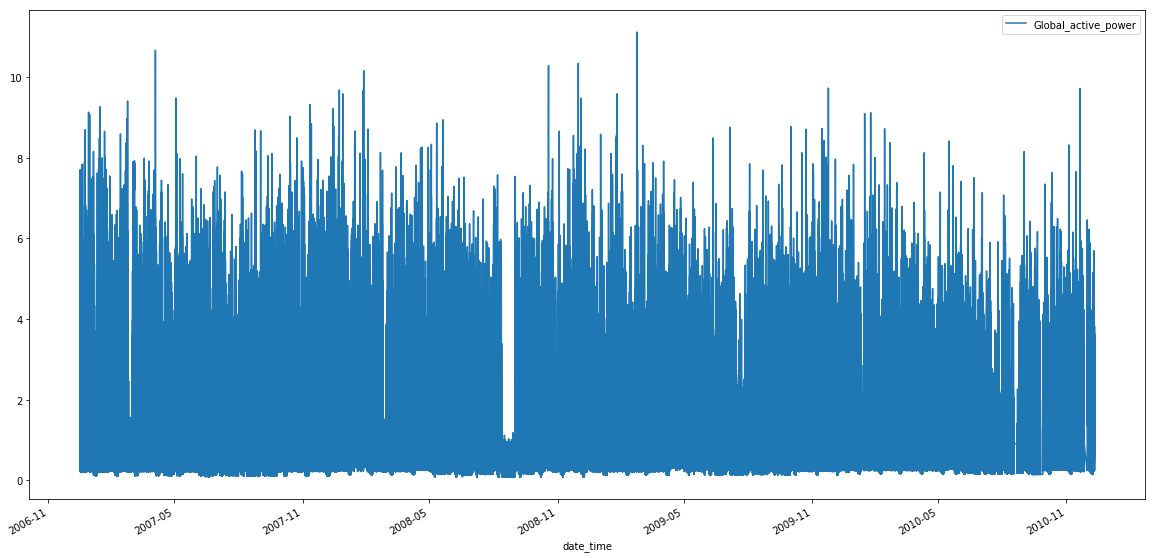

In [84]:
energy.plot.line(x='date_time', y='Global_active_power',  figsize=(20, 10))

In [86]:
energy.set_index(energy['date_time'], inplace=True)

In [87]:
# add a new column for hour of the day in the dataframe
energy['hour_of_day'] = energy['date_time'].dt.hour

In [88]:
energy.dtypes

date_time                datetime64[ns]
Date                             object
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
hour_of_day                       int64
dtype: object

In [89]:
#energy[energy.date_time.dt.month == 7].head()
energy.shape


(2075259, 11)

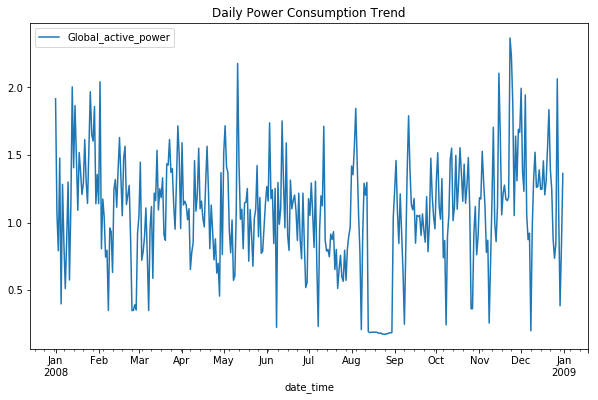

In [90]:
energy[energy.date_time.dt.year == 2008].resample('D').mean().plot(
    y='Global_active_power', 
    title='Daily Power Consumption Trend', 
    figsize=(10, 6))

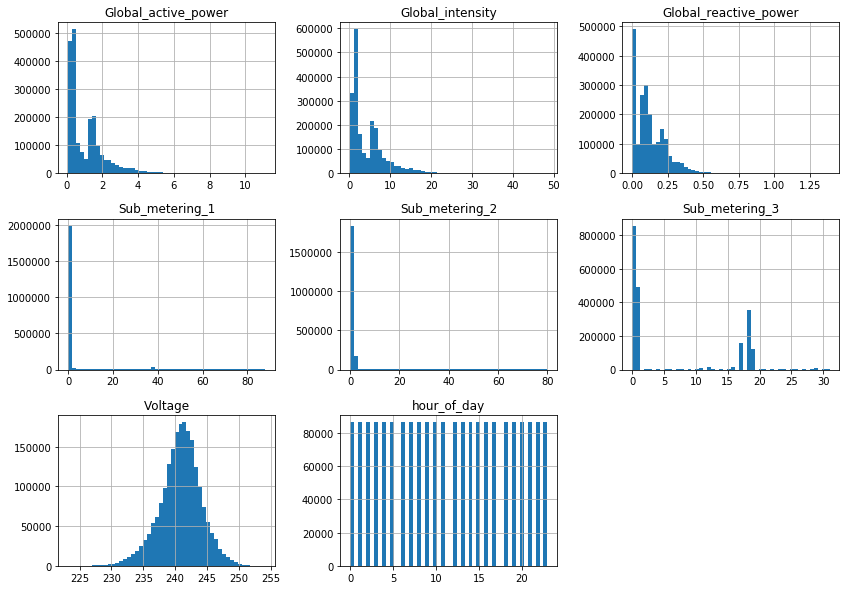

In [91]:
energy.hist(figsize=(14,10), bins=50);

In [94]:
energy.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour_of_day
Global_active_power,1.000000,0.246362,-0.395647,0.998884,0.484388,0.434581,0.639681,0.279743
Global_reactive_power,0.246362,1.000000,-0.111775,0.265558,0.123135,0.139438,0.090631,0.126429
Voltage,-0.395647,-0.111775,1.000000,-0.407454,-0.194261,-0.165659,-0.260498,-0.173752
Global_intensity,0.998884,0.265558,-0.407454,1.000000,0.489283,0.440359,0.627569,0.280122
Sub_metering_1,0.484388,0.123135,-0.194261,0.489283,1.000000,0.055102,0.103769,0.107944
Sub_metering_2,0.434581,0.139438,-0.165659,0.440359,0.055102,1.000000,0.082118,0.086746
Sub_metering_3,0.639681,0.090631,-0.260498,0.627569,0.103769,0.082118,1.000000,0.113233
hour_of_day,0.279743,0.126429,-0.173752,0.280122,0.107944,0.086746,0.113233,1.000000


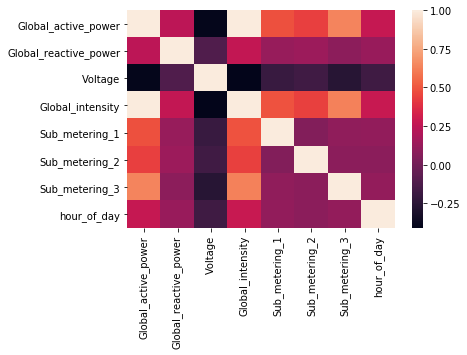

In [95]:
sns.heatmap(energy.corr());
# Global_acctive_power and Global_intensity seem to be highly correlated but more importantly proportional by definition of physics
# Also Global_acctive_power and Sub_metering_3 seem to have correlated as both of these are affected  by the outside temperature

In [96]:
energy[energy.date_time.dt.year == 2007].resample('H').mean().head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour_of_day
date_time,,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0,0
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0,1
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0,2
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0,3
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0,4


In [97]:
energy_2007 = energy[energy.date_time.dt.year == 2007].resample('H').mean().copy()

In [98]:
energy_2007.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour_of_day
date_time,,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0,0
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0,1
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0,2
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0,3
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0,4


In [137]:
print(energy_2007.index.quarter == 4)

[False False False ...  True  True  True]


In [53]:
energy_2007.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
hour_of_day                int64
dtype: object

In [119]:
energy_2007.shape

(8760, 8)

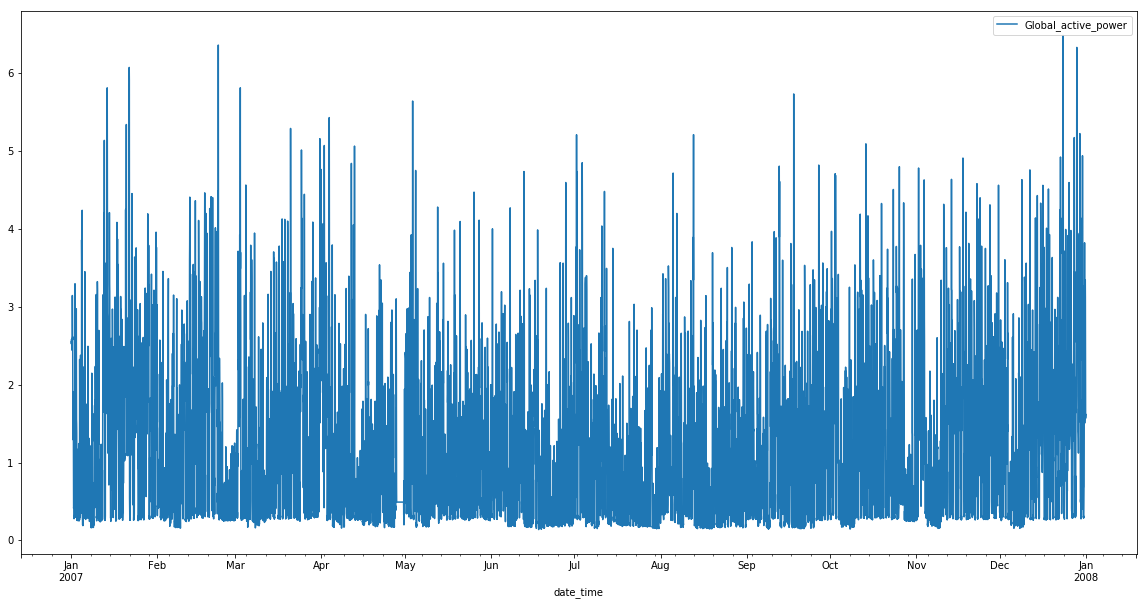

In [102]:
energy_2007.plot.line( y='Global_active_power',  figsize=(20, 10))

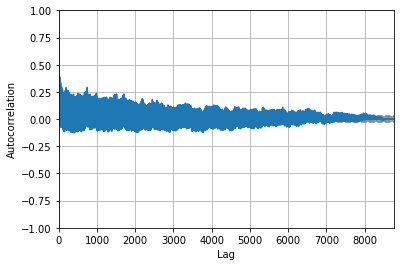

In [112]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(energy_2007.Global_active_power);

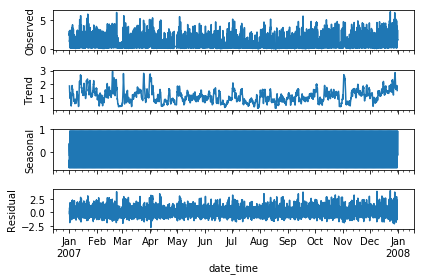

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(energy_2007.Global_active_power, freq=24)
decomposition.plot()
plt.show()

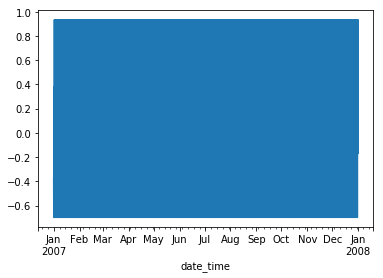

In [106]:
seasonal = decomposition.seasonal 
seasonal.plot();

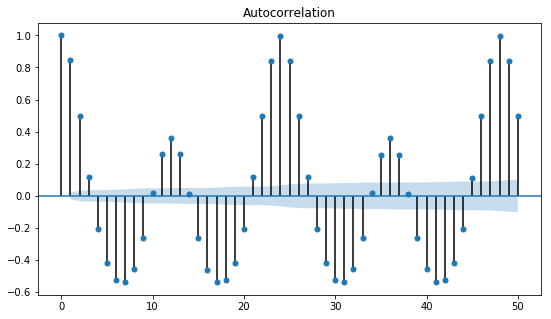

In [194]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(seasonal, lags=50, ax = ax)
plt.show()

/home/amardeep/anaconda/envs/cog/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


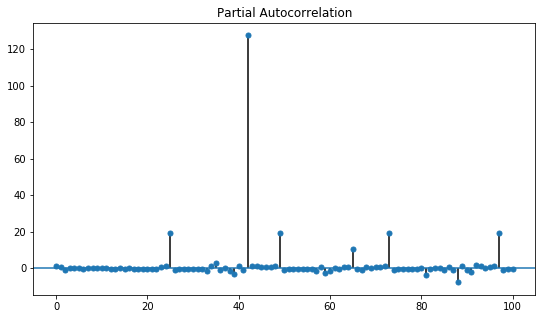

In [184]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(seasonal, lags=100, ax=ax)
plt.show()

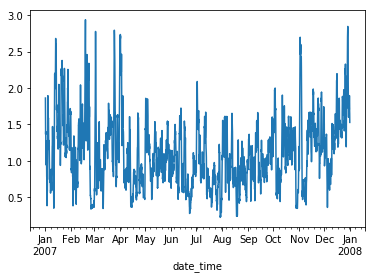

In [107]:
trend = decomposition.trend 
trend.plot();

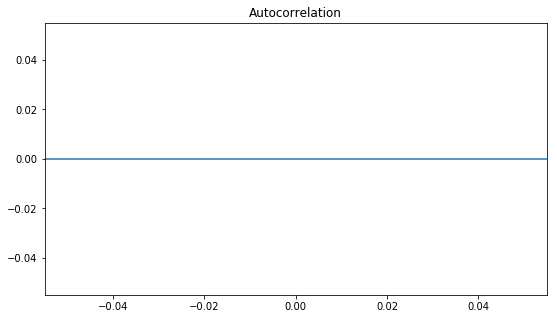

In [186]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(trend, lags=100, ax = ax)
plt.show()

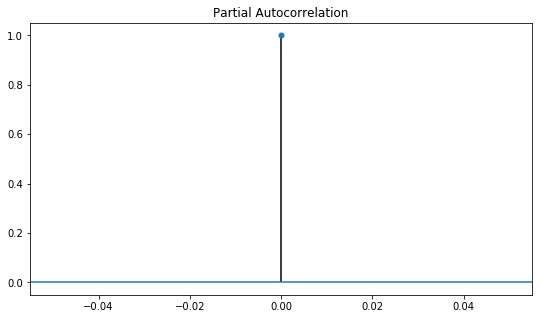

In [187]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(trend, lags=30, ax = ax)
plt.show()

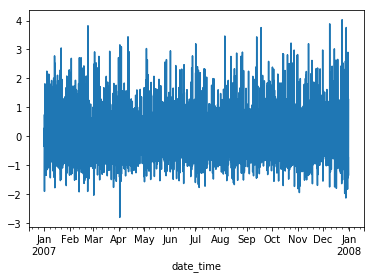

In [108]:
resid = decomposition.resid
resid.plot();

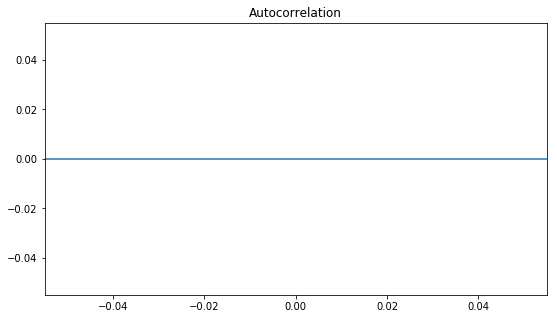

In [113]:
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(resid, lags=1000, ax = ax)
plt.show()

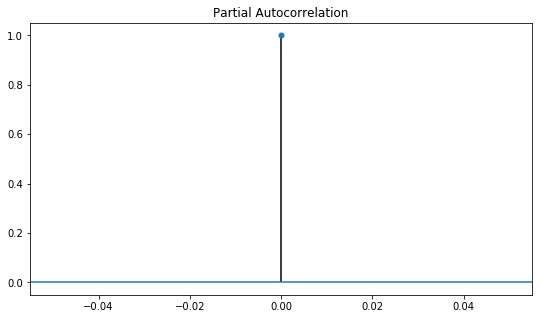

In [114]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(resid, lags=1000, ax=ax)
plt.show()
# We observe that the residuals dont show a significant autocorrelation

In [123]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determining rolling statistics:
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Performing the Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

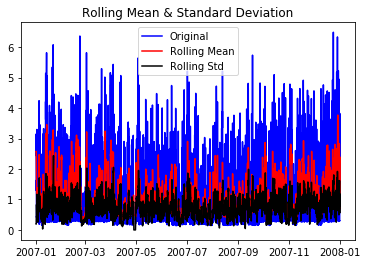

Results of Dickey-Fuller Test:
Test Statistic                -1.045884e+01
p-value                        1.375900e-18
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [124]:
test_stationarity(energy_2007.Global_active_power)
# We observe that the test statistic value is very high compared to Critical values we need to make the data stationary

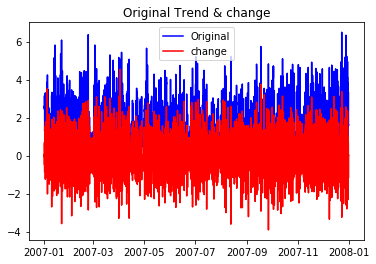

In [127]:
energy_2007['change'] = energy_2007.Global_active_power.diff(1);

orig = plt.plot(energy_2007.Global_active_power, color='blue',label='Original')
change = plt.plot(energy_2007.change, color='red', label='change')
plt.legend(loc='best')
plt.title('Original Trend & change')
plt.show(block=False)


In [163]:
# Creare train and test data with 3 and 1 quarter data respectively
quarters = [1,2,3]
train = energy_2007[energy_2007.index.quarter.isin(quarters)]
test = energy_2007[energy_2007.index.quarter == 4]

In [161]:
test.shape

(2208, 9)

In [162]:
train.shape

(6552, 9)

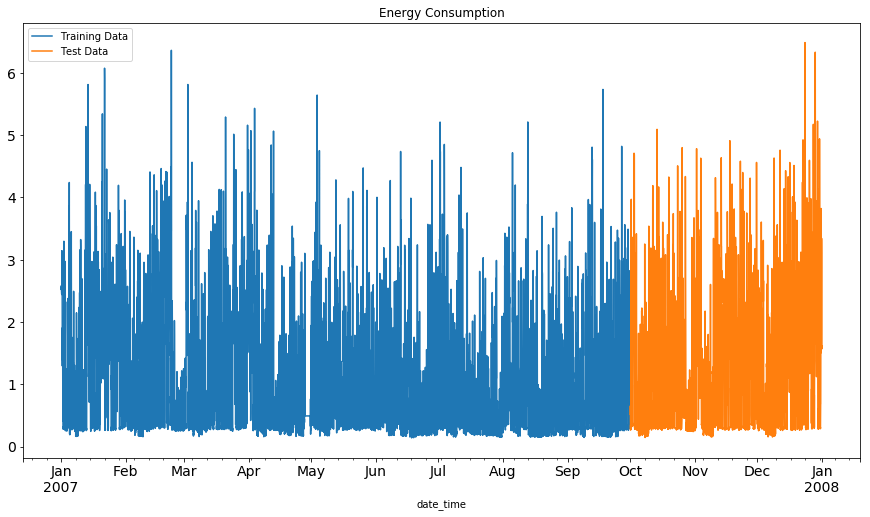

In [197]:
train.Global_active_power.plot(figsize=(15,8), title= 'Energy Consumption', fontsize=14, label='Training Data')
test.Global_active_power.plot(figsize=(15,8), title= 'Energy Consumption', fontsize=14, label='Test Data')
plt.legend(loc='best')
plt.show()

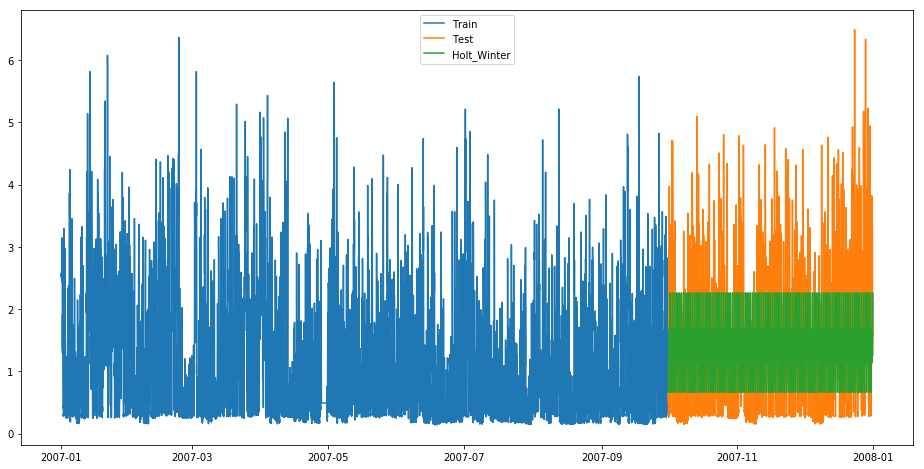

In [198]:
y_hat_avg = test.copy()

fit1 = ExponentialSmoothing(np.asarray(train['Global_active_power']) ,seasonal_periods=24 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Global_active_power'], label='Train')
plt.plot(test['Global_active_power'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

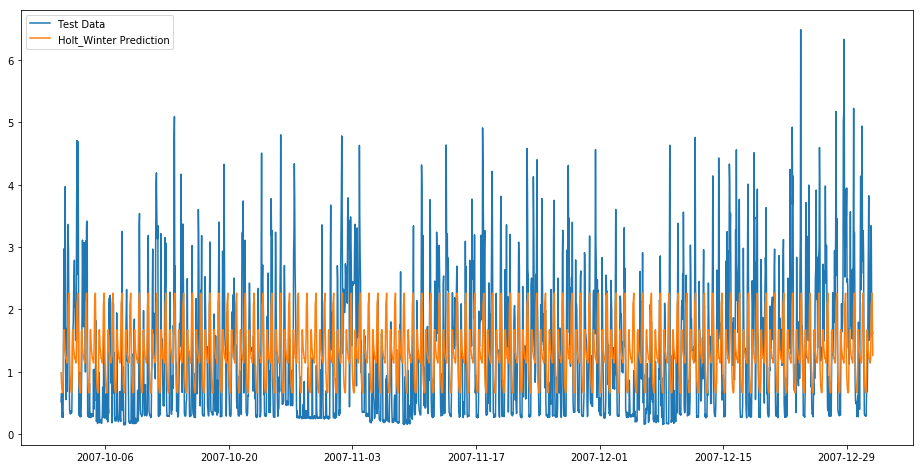

In [195]:
plt.figure(figsize=(16,8))
#plt.plot(train['Global_active_power'], label='Train')
plt.plot(test['Global_active_power'], label='Test Data')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter Prediction')
plt.legend(loc='best')
plt.show()

In [175]:
rms = sqrt(mean_squared_error(test.Global_active_power, y_hat_avg.Holt_Winter))
print(rms)

0.9326832792834037


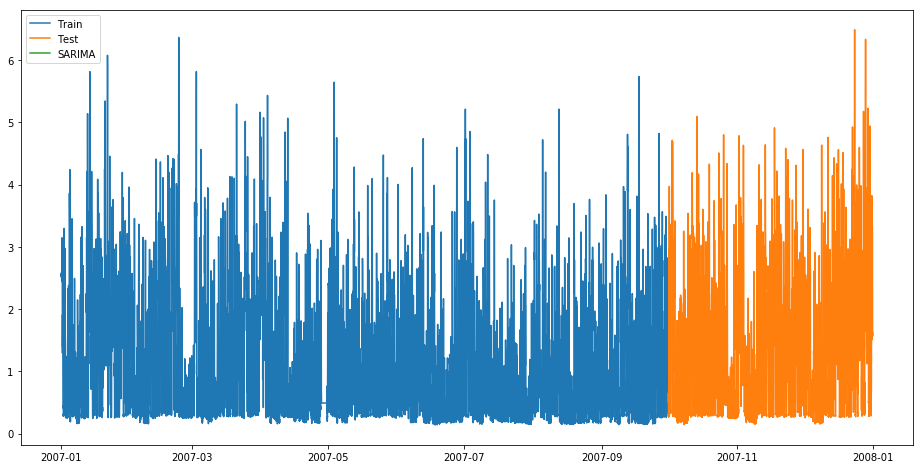

In [188]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Global_active_power, order=(1, 0, 1),seasonal_order=(1,0,1,24)).fit()
y_hat_avg['SARIMA'] = fit1.predict(dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Global_active_power'], label='Train')
plt.plot(test['Global_active_power'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [189]:
rms = sqrt(mean_squared_error(test.Global_active_power, y_hat_avg.SARIMA))
print(rms)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').